Рассмотрим Conv2d слой с out_channel=3, kernel_size=2, stride=1, padding = 0, dilation=1. Пусть вход в него имеет размеры (2,2,3,3), где 2 – размер батча, 2 – число каналов, 3х3 – размеры изображения.
1. Какой будет размер на выходе?
2. Пусть одна из картинок на входе ( [10_7, 5_7, 5_9], [5_8,5_6,0_6], [1_2,0_2,1_8]), а веса фильтра с out_channels = 2: ([ 1,0], [0,1], [1,1], …)
Что будет на выходе?
3. То же самое, но padding = 1

Лог.регрессия

In [1]:
!pip3 install torch torchvision

In [2]:
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using', DEVICE)

Using cpu


In [3]:
import torch.nn as nn

simple_conv = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=2)

ex = torch.tensor([
    [[10, 7], [5, 7], [5, 9]],
    [[5, 8], [5, 6], [0, 6]],
    [[1, 2], [0, 2], [1, 8]]
    ], dtype=torch.float)

weight = torch.tensor(
    [
     [
        [[1, 0], [0, 1]],
        [[0, 1], [1, 1]]
      ],
     
     [
        [[0, 1], [1, 1]],
        [[1, 0], [0, 0]]
      ],
    ], dtype=torch.float
    ).permute(2, 3, 0, 1)

ex = ex.unsqueeze(0).permute(0, 3, 1, 2)

simple_conv.bias.data = torch.zeros(2)
simple_conv.weight.data = weight

simple_conv(ex).permute(0, 2, 3, 1)


tensor([[[[30., 32.],
          [20., 32.]],

         [[13., 22.],
          [14., 14.]]]], grad_fn=<PermuteBackward0>)

In [4]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Выбераем аугментации
# transforms - что необходимо сделать с картинкой перед тем,
#   как передать ее в батч
train_trans = transforms.Compose([
                                   transforms.RandomCrop(28, padding=4), # padding=4 - оградили четыремя нулями по бокам, затем случайно вырезали из нее картику 28х28
                                   transforms.ToTensor(), # преобразует картинку в torch для pytorch
                                   transforms.Normalize((0.1307, ), (0.3081,)) # 1 число - средняя яркость пикселей в MNIST, 
                                  # 2 число - среднее std, т.е. отклонение по MNIST от этого среднего
                                  # нормальное отклонение равно 1
])

test_trans = transforms.Compose([
                                   transforms.Resize(28),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307, ), (0.3081,))
])

# Загружаем данные
dataset = datasets.MNIST(root='drive/temp', download=True, 
                         transform=train_trans)
test_data = datasets.MNIST(root='drive/temp', download=True, train = False,
                         transform=test_trans)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting drive/temp/MNIST/raw/train-images-idx3-ubyte.gz to drive/temp/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting drive/temp/MNIST/raw/train-labels-idx1-ubyte.gz to drive/temp/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting drive/temp/MNIST/raw/t10k-images-idx3-ubyte.gz to drive/temp/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting drive/temp/MNIST/raw/t10k-labels-idx1-ubyte.gz to drive/temp/MNIST/raw



In [5]:
datasets.MNIST?

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


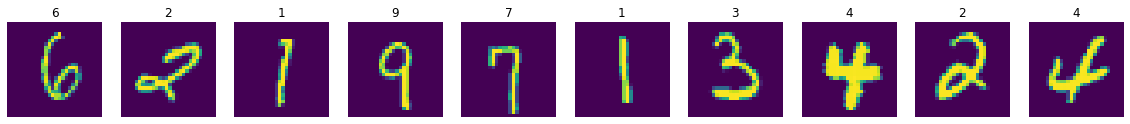

In [6]:
# Проверяем разметку
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(20, 10))

for i in range(10):
  r_ind = random.randint(0, len(dataset) - 1)
  plt.subplot(1, 10, i+1)
  plt.title(dataset.train_labels[r_ind].numpy())
  plt.imshow(dataset.train_data[r_ind])
  plt.axis('off')
plt.show()

In [7]:
# Создаем генераторы батчей
# Делаем итерируемость с помощью цикла for, для этого делаем генератор
# Подаем dataset, размер, флаг shuffle чтобы изображения в перемешку, num_workers - сколько ядер нужно распараллелить для вычислений
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, batch_size=256, num_workers=4, shuffle=True) 
test_loader = DataLoader(test_data, batch_size=256, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
ex = train_loader.dataset[10][0]

ex.shape, torch.mean(ex), torch.std(ex) # среднее и отклонение

(torch.Size([1, 28, 28]), tensor(0.0393), tensor(1.0524))

In [9]:
train_loader?

In [10]:
len(train_loader), len(train_loader.dataset) 

(235, 60000)

In [19]:
# Пишем классификатор

import torch.nn as nn

class DummyClassifier(nn.Module):

  def _init_weights(self):
    nn.init.normal_(self.classifier.weight, 0, 1e-3)
    nn.init.constant_(self.classifier.bias, 0)
      
  def __init__(self, num_classes=10, init_weights=True):
    super(DummyClassifier, self).__init__()
    self.classifier = nn.Linear(28*28*1, num_classes) # переводит размерность 28*28*1 в размер входной картинки, в данном случае 10
    if init_weights:
      self._init_weights()
      
  def forward(self, x):
    x = x.view(x.size(0), -1) # пока не пишем сигмойды. Когда х подается на вход, то изначальная размерность у него (228, 1, 28, 28)
    # 1 - количество каналов, 28 и 28 - размер картинки, 228 - размер батча. Данный вход превращаем в Tenso с размерами (228, 28*28*1), 
    # Это и делаем строчкой x = x.view(x.size(0), -1)
    return self.classifier(x)
    '''
    def _init_weights(self):
      nn.init.normal_(self.classifier.weight, 0, 1e-3)
      nn.init.constant_(self.classifier.bias, 0)
    '''

    
linear_model = DummyClassifier().to(DEVICE)


# Кросс-энтропия
# nn.CrossEntropyLoss:
# p = (p0,...., pc) ; y = (0, 1, ...0) - у - это правильные предсказания, в случае с Мистом для какой-то конкретной картинки
# единица - это вероятность именного этого класса, ноль - вероятность любого другого класса
# Мы подгоняем полученный вектор вероятности к правильному настоящему y.

# Эти вектора - вектора вероятностей. У них есть свойство, что их сумма (покоординатно) дает 1
# Это называется NLL
# Он считается следующим образом: - сумма от 0 до С: Е yi log(p1) -> min
# Он усредняется по батчу


In [20]:
# Выбираем loss и optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2, momentum=0.8)

In [21]:
# Учим модель
from tqdm import tqdm 

reporter = tqdm(enumerate(train_loader, 0), total=len(train_loader))

for i, data in reporter: # единичная итерация, что очень мало, надо использовать несколько эпох
  inputs, targets = data[0].to(DEVICE), data[1].to(DEVICE) # батч, который выходит от train_loader это пара, 1 элемент - картинки, 2 - метки, таргеты
  # print(data[0], data[1])
  # Forward pass
  predictions = linear_model(inputs) # делаем Forward
  # Estimate predictions quality
  loss = criterion(predictions, targets) # оценка нашего предсказания

  # Backward pass
  optimizer.zero_grad() # Делаем zero_grad, иначе optimizer сохранит тот loss, который остался в предыдущей итерации, т.е. градиенты будут накапливаться
  loss.backward() # делаем Backward

  optimizer.step()

  if i % 50 == 0:
    cur_loss = loss.item()
    reporter.set_description('loss %.2f'%cur_loss)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
loss 1.58: 100%|██████████| 235/235 [00:13<00:00, 17.16it/s]


In [22]:
# Проверяем качество модели

reporter2 = tqdm(enumerate(test_loader), total=len(test_loader))

total_examples = len(test_loader.dataset)
num_matches = 0

for i, data in reporter2:
  with torch.no_grad(): 
    # no_grad - не сохраняет предыдущие градиенты, т.е. мы указываем,
    # что дальше у нас нет обучения нейронной сети, не считаются ни Forward,
    # ни Backward, а просто анализируется статистика нашей модели
    # При анализе эпохи не нужны.
    inputs, targets = data[0].to(DEVICE), data[1].to(DEVICE)

    predictions = linear_model(inputs)

    _, label_predictions = predictions.max(1)

    num_matches += label_predictions.eq(targets).sum().item()

print('\nTest accuracy: %.2f%%'%(100.*num_matches/total_examples))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 40/40 [00:02<00:00, 19.63it/s]


Test accuracy: 66.49%


Test accuracy: 66.49%

Почему качество линейной модели такое низкое? Как это исправить?



4. Сверточная сеть

In [23]:
nn.Conv2d?

In [24]:
nn.AvgPool2d?

In [56]:
class LeNet3(nn.Module):
  def __init__(self, num_classes=10, init_weights=True):
    super(LeNet3, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=8) # out_channels - число выходных каналов и число фильтров, 
    #  есть еще groups: если groups = 1, или если groups равен числу фильтров.
    self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
    self.relu = nn.ReLU()
    # x имеет размерность (228, 1, 28, 28). Изменилась размерность на (228, 10, 21, 21), т.к. крайние точки мы убрали (они не могут быть центрами фильтра)
    # итоговая размерность (228, 10, 10, 10) 
    
    self.clf1 = nn.Linear(10*10*10, 128)
    self.clf2 = nn.Linear(128, 10)

    if init_weights:
      self._init_weights()
    
  def forward(self, x):
    x = self.relu(self.conv1(x)) # Обязательно требуется активация (relu)
    x = self.relu(self.pool1(x))

    x = x.view(x.size(0), -1)

    x = self.relu(self.clf1(x))
    x = self.clf2(x)

    return x

  def _init_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 1e-2)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Conv2d):

        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        nn.init.constant_(m.bias, 0)


conv_model1 = LeNet3().to(DEVICE)


In [57]:
ex = torch.randn(2, 1, 28, 28).to(DEVICE)
conv_model(ex).shape

torch.Size([2, 10])

In [60]:
conv_model1?

torch.Size([2, 10]) - т.е. для двух элементов батчей по 10 предсказаний


In [63]:
optimizer = optim.SGD(conv_model1.parameters(), lr=1e-2, momentum=0.8)

# Учим модель
from tqdm import tqdm 

reporter = tqdm(enumerate(train_loader, 0), total=len(train_loader))

for i, data in reporter: # единичная итерация, что очень мало, надо использовать несколько эпох
  inputs, targets = data[0].to(DEVICE), data[1].to(DEVICE) # батч, который выходит от train_loader это пара, 1 элемент - картинки, 2 - метки, таргеты
  # print(data[0], data[1])
  # Forward pass
  predictions = conv_model1(inputs) # делаем Forward
  # Estimate predictions quality
  loss = criterion(predictions, targets) # оценка нашего предсказания

  # Backward pass
  optimizer.zero_grad() # Делаем zero_grad, иначе optimizer сохранит тот loss, который остался в предыдущей итерации, т.е. градиенты будут накапливаться
  loss.backward() # делаем Backward

  optimizer.step()

  if i % 50 == 0:
    cur_loss = loss.item()
    reporter.set_description('loss %.2f'%cur_loss)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
loss 0.71: 100%|██████████| 235/235 [00:29<00:00,  8.05it/s]


In [66]:
# Проверяем качество модели

reporter2 = tqdm(enumerate(test_loader), total=len(test_loader))

total_examples = len(test_loader.dataset)
num_matches = 0

for i, data in reporter2:
  with torch.no_grad(): 
    # no_grad - не сохраняет предыдущие градиенты, т.е. мы указываем,
    # что дальше у нас нет обучения нейронной сети, не считаются ни Forward,
    # ни Backward, а просто анализируется статистика нашей модели
    # При анализе эпохи не нужны.
    inputs, targets = data[0].to(DEVICE), data[1].to(DEVICE)

    predictions = conv_model1(inputs) # даем на вход нашей модели inputs

    _, label_predictions = predictions.max(1)

    num_matches += label_predictions.eq(targets).sum().item()

print('\nTest accuracy: %.2f%%'%(100.*num_matches/total_examples))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 40/40 [00:02<00:00, 15.20it/s]


Test accuracy: 89.86%


Test accuracy: 89.86%

Задание.

1. Распишите, как меняются: размеры картинок, receptive field при прохождении по слоям LeNet3. С помощью этого исправьте размерность на входе классификатора.
2. Сколько всего параметров у LeNet3? Сравните с количеством параметров у линейной модели
3. Насколько важны регуляризация и инициализация параметров? Попробуйте с/без dropout/инициализации, сравните результаты.
4. Напигите свою модель, использующую параметров не больше, чем лог.регрессия, при этом имеющую качество не хуже, чем LeNet3 на тесте (советую обернуть обучение и тест модели в отдельные методы train и evalute).
